<a href="https://colab.research.google.com/github/fatihamaazaz/Aide-a-la-decision-multicritere/blob/main/MCDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**étude comparative des méthodes multicriteres (3 methodes) avec simulation**

###**Implémentation des methodes**

In [ ]:
import numpy as np
import pandas as pd 
import math
from numpy.linalg import norm
from astropy.table import Table
import matplotlib.pyplot as plt
import scipy.stats as stats

####**TOPSIS**

Fonction de normalisation des données

In [ ]:
def Normalize(m, n, weights):
  # m c'est le dataframe, n c'est le nombre de criteres et 
  # weights c'est les poids associent aux criteres 
    for i in range(1, n):
        t = 0
        # Calculating Root of Sum of squares of a particular column
        for j in range(len(m)):
            t = t + m.iloc[j, i]**2
        t = t**0.5
        # Weighted Normalizing a element
        for j in range(len(m)):
            m.iat[j, i] = (m.iloc[j, i] / t)*weights[i-1]

Fonction de calcul de l ideal best et l ideal worst

In [ ]:
def Calc_Values(m, n, types):
  # m c'est le dataframe, n c'est le nombre de criteres et 
  # types c'est l'influence des criteres (a maximiser (1) ou a minimiser (-1))
    p_sln = (m.max().values)[1:]
    n_sln = (m.min().values)[1:]
    for i in range(1, n):
        if types[i-1] == -1:
            p_sln[i-1], n_sln[i-1] = n_sln[i-1], p_sln[i-1]
    return p_sln, n_sln

Fonction de calcul de la distance euclidienne par rapport a l ideal best et l ideal worst et TOPSIS score

In [ ]:
def topsis_score(a,p_sln,n_sln):
  score = [] # Topsis score
  pp = [] # distance positive
  nn = [] # distance negative
  # Calculating distances and Topsis score for each row
  for i in range(len(a)):
      t_p, t_n = 0, 0
      for j in range(1, a.shape[1]):
          t_p = t_p + (p_sln[j-1] - a.iloc[i, j])**2
          t_n = t_n + (n_sln[j-1] - a.iloc[i, j])**2
      t_p, t_n = t_p**0.5, t_n**0.5
      score.append(t_n/(t_p + t_n))
      nn.append(t_n)
      pp.append(t_p)
    
  # Appending new columns in dataset   
  a['distance positive'] = pp
  a['distance negative'] = nn
  a['Topsis Score'] = score

La fonction finale

In [ ]:
def topsis(m,weights,types):
  # m c'est le dataframe
  # weights c'est les poids des criteres
  # types c'est l'influence des criteres (a maximiser (1) ou a minimiser (-1))
  Normalize(m,m.shape[1],weights)
  p_sln , n_sln = Calc_Values(m,m.shape[1],types)
  topsis_score(m,p_sln,n_sln)
  m['rank'] = (m['Topsis Score'].rank(method='max', ascending=False))
  m = m.astype({"rank": int})

####**VIKOR**

Version 2 de la fonction de determination de l'ideal best et l'ideal worst pour chaque critere

In [ ]:
def best_worst(a, types):
  # a c'est le dataframe et types c'est 
	# l'influence des criteres (a maximiser (1) ou a minimiser (-1))
    f = np.zeros((types.shape[0], 2))
    for i in range(types.shape[0]):
        if types[i] == 1:
            f[i, 0] = max(a.iloc[:,i])
            f[i, 1] = min(a.iloc[:,i])
        elif types[i] == -1:
            f[i, 0] = min(a.iloc[:,i])
            f[i, 1] = max(a.iloc[:,i])
    return f

Fonction de calcul des valeurs S et R (voir rapport)

In [ ]:
def SR(a, b_w, weights):
  # a c'est le dataframe et b_w c'est la meileure et la mauvaise valeur
  # de chaque critere et weights c'est les poids des criteres
  s = np.zeros(a.shape[0])
  r = np.zeros(a.shape[0])
  for i in range(a.shape[0]):
      k = 0
      o = 0
      for j in range(a.shape[1]):
          k = k + weights[j] * (b_w[j, 0] - a.iloc[i, j]) \
                  / (b_w[j, 0] - b_w[j, 1])
          u = weights[j] * (b_w[j, 0] - a.iloc[i, j]) \
              / (b_w[j, 0] - b_w[j, 1])
          if u > o:
              o = u
              r[i] = round(o, 3)
          else:
              r[i] = round(o, 3)
      s[i] = round(k, 3)
  return s, r

Fonction de calcul de l'indice de VIKOR

In [ ]:
def vikor_index(s, r, n):
  # n c'est le nombre de critere et s et r sont les valeurs S et R (voir rapport)
  q = np.zeros(s.shape[0])
  for i in range(s.shape[0]):
      q[i] = round((((n + 1) / (2 * n)) *
          (s[i] - min(s)) / (max(s) - min(s)) +
          (1 - (n + 1) / (2 * n)) *
          (r[i] - min(r)) / (max(r) - min(r))), 3)
  return q

Fonction finale

In [ ]:
def vikor(m, weights, types):
  #m c'est le dataframe, types c'est c'est l'influence des criteres (a maximiser (1) ou a minimiser (-1))
  # weights c'est les poids associent a chaque critere
  b_w = best_worst(m, types)
  s, r = SR(m, b_w, weights)
  q = vikor_index(s, r, m.shape[1])
  m['R'] = r
  m['S'] = s
  m['VIKOR index'] = q
  m['rank'] = (m['VIKOR index'].rank(method='max', ascending=False))
  m = m.astype({"rank": int})

####**WPM**

Fonction de normalisation

In [ ]:
def norm_wpm(a, t):
  #m c'est le dataframe, t c'est l'influence des criteres (a maximiser (1) ou a minimiser (-1))
  for j in range(a.shape[1]):
      if t[j] == -1:
        mi = min(a.iloc[:,j])
        for i in range(a.shape[0]):
          a.iat[i,j] = mi/a.iloc[i,j]
      elif t[j] == 1:
        ma = max(a.iloc[:,j])
        for i in range(a.shape[0]):
          a.iat[i,j] = a.iloc[i,j]/ma

Fonction de calcul de la puissance des criteres

In [ ]:
def puissance(a, weights):
  # a c'est le dataframe et weights c'est les poids des criteres
  for i in range(a.shape[0]):
    for j in range(a.shape[1]):
      a.iat[i, j]=math.pow(a.iloc[i,j],weights[j])

Fonction de calcul de la multiplication (voir rapport)

In [ ]:
def multiplication(a):
  # a c'est le dataframe
  q = np.ones(a.shape[0])
  for i in range(a.shape[0]):
    for j in range(a.shape[1]):
      q[i] *= a.iloc[i, j]
  a['wpm score'] = q

Fonction finale

In [ ]:
def wpm(m, weights, types):
  #m c'est le dataframe, types c'est c'est l'influence des criteres (a maximiser (1) ou a minimiser (-1))
  # weights c'est les poids associent a chaque critere
  norm_wpm(m, types)
  puissance(m, weights)
  multiplication(m)
  m['rank'] = (m['wpm score'].rank(method='max', ascending=False))
  m = m.astype({"rank": int})

###**Exemple d'application**

####**Data**

Il s'agit des donnees sur des vans electriques, dans un fichier .csv avec des parametres lies a ces derniers

In [ ]:
dataframe = pd.read_csv('vans.csv')
dataframe.head()

,code,name,manufacturer,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price
0,A1,EVI MD,Electric Vehicles International,3000,96,145,200,610,10.0,120,99.0,120.0
1,A2,EVI Walk-In Van,Electric Vehicles International/Freightliner ...,2000,100,145,200,610,10.0,120,99.0,90.0
2,A3,e-NV200+,Nissan,705,120,170,80,270,4.0,30,24.0,25.0
3,A4,e-Wolf Omega 0.7,e-Wolf,613,140,180,140,400,8.0,40,24.2,50.0
4,A5,Minicab-MiEV Truck,Mitsubishi Motors Corp.,350,100,110,30,196,4.5,15,10.5,12.9


on élimine les données de type caractéres

In [ ]:
data = dataframe[dataframe.columns[3:]]
data.head()

,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price
0,3000,96,145,200,610,10.0,120,99.0,120.0
1,2000,100,145,200,610,10.0,120,99.0,90.0
2,705,120,170,80,270,4.0,30,24.0,25.0
3,613,140,180,140,400,8.0,40,24.2,50.0
4,350,100,110,30,196,4.5,15,10.5,12.9


####**Weights**

In [ ]:
weights = np.array([0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111])

####**Types**

Cet etape permet de determiner quel critere a maximiser et lequel a minimiser

In [ ]:
types = np.array([1, 1, 1, 1, 1, -1, -1, 1, -1])

####**Cas 1: 10 alternatives et 9 criteres**

Definition de dataframe

In [ ]:
data_1 = data.copy()
data_1.head()

,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price
0,3000,96,145,200,610,10.0,120,99.0,120.0
1,2000,100,145,200,610,10.0,120,99.0,90.0
2,705,120,170,80,270,4.0,30,24.0,25.0
3,613,140,180,140,400,8.0,40,24.2,50.0
4,350,100,110,30,196,4.5,15,10.5,12.9


Utilisation des méthodes deja implementés



1.   **TOPSIS**


In [ ]:
topsis_data = data_1.copy()


In [ ]:
topsis(topsis_data, weights, types)

In [ ]:
topsis_data

,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price,distance positive,distance negative,Topsis Score,rank
0,3000,0.030653,0.034779,0.063279,0.057509,0.048100,0.060413,0.070709,0.076980,0.086197,0.109249,0.558971,3.0
1,2000,0.031930,0.034779,0.063279,0.057509,0.048100,0.060413,0.070709,0.057735,0.088079,0.098461,0.527828,4.0
2,705,0.038317,0.040775,0.025312,0.025455,0.019240,0.015103,0.017142,0.016038,0.085485,0.080502,0.484990,5.0
3,613,0.044703,0.043174,0.044295,0.037711,0.038480,0.020138,0.017284,0.032075,0.056528,0.095317,0.627727,1.0
4,350,0.031930,0.026384,0.009492,0.018478,0.021645,0.007552,0.007499,0.008275,0.101881,0.084554,0.453532,8.0
5,350,0.031930,0.023986,0.009492,0.018478,0.021645,0.007552,0.007499,0.009943,0.101191,0.084537,0.455165,7.0
6,350,0.031930,0.035978,0.009492,0.018478,0.033670,0.017620,0.011428,0.011996,0.096582,0.077843,0.446283,9.0
7,635,0.035123,0.040775,0.015503,0.018855,0.038480,0.017620,0.016070,0.020207,0.086562,0.078598,0.475890,6.0
8,340,0.047896,0.038377,0.034804,0.047138,0.028860,0.005034,0.024998,0.028868,0.062711,0.096595,0.606351,2.0
9,750,0.018200,0.026384,0.003164,0.007542,0.038480,0.060413,0.024998,0.015653,0.120419,0.050198,0.294214,10.0


2.   **VIKOR**



In [ ]:
vikor_data = data_1.copy()

In [ ]:
vikor(vikor_data, weights, types)

In [ ]:
vikor_data

,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price,R,S,VIKOR index,rank
0,3000,96,145,200,610,10.0,120,99.0,120.0,0.111,0.446,0.547,6.0
1,2000,100,145,200,610,10.0,120,99.0,90.0,0.111,0.452,0.555,5.0
2,705,120,170,80,270,4.0,30,24.0,25.0,0.096,0.414,0.062,10.0
3,613,140,180,140,400,8.0,40,24.2,50.0,0.100,0.428,0.199,9.0
4,350,100,110,30,196,4.5,15,10.5,12.9,0.111,0.579,0.717,4.0
5,350,100,100,30,196,4.5,15,10.5,15.5,0.111,0.596,0.738,2.0
6,350,100,150,30,196,7.0,35,16.0,18.7,0.111,0.589,0.729,3.0
7,635,110,170,49,200,8.0,35,22.5,31.5,0.099,0.549,0.323,8.0
8,340,150,160,110,500,6.0,10,35.0,45.0,0.111,0.365,0.444,7.0
9,750,57,110,10,80,8.0,120,35.0,24.4,0.111,0.802,1.000,1.0


3.   **WPM**


In [ ]:
wpm_data = data_1.copy()

In [ ]:
wpm(wpm_data, weights, types)

In [ ]:
wpm_data

,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price,wpm score,rank
0,1.000000,0.951627,0.976264,1.000000,1.000000,0.903210,0.758757,1.000000,0.780530,0.496953,2.0
1,0.955952,0.955952,0.976264,1.000000,1.000000,0.903210,0.758757,1.000000,0.805880,0.492722,3.0
2,0.851384,0.975514,0.993670,0.903210,0.913428,1.000000,0.885099,0.854331,0.929128,0.478363,4.0
3,0.838260,0.992364,1.000000,0.961148,0.954198,0.925882,0.857257,0.855120,0.860262,0.445455,5.0
4,0.787658,0.955952,0.946756,0.809960,0.881494,0.987000,0.955952,0.779362,1.000000,0.374272,7.0
5,0.787658,0.955952,0.936783,0.809960,0.881494,0.987000,0.955952,0.779362,0.979807,0.362852,8.0
6,0.787658,0.955952,0.979948,0.809960,0.881494,0.939720,0.870070,0.816700,0.959588,0.337567,9.0
7,0.841550,0.966129,0.993670,0.855335,0.883475,0.925882,0.870070,0.848228,0.905575,0.377776,6.0
8,0.785126,1.000000,0.987000,0.935738,0.978150,0.955952,1.000000,0.890904,0.870391,0.525772,1.0
9,0.857257,0.898078,0.946756,0.716895,0.797964,0.925882,0.758757,0.890904,0.931639,0.243130,10.0


**Comparaison des methodes**

In [ ]:
a = [f'A{i+1}' for i in range(10)]
b = topsis_data['rank'].to_numpy()
c = vikor_data['rank'].to_numpy()
d = wpm_data['rank'].to_numpy()
t = Table([a, b, c, d], names=('alternatives', 'TOPSIS', 'VIKOR', 'WPM'))
t

alternatives,TOPSIS,VIKOR,WPM
str3,float64,float64,float64
A1,3.0,6.0,2.0
A2,4.0,5.0,3.0
A3,5.0,10.0,4.0
A4,1.0,9.0,5.0
A5,8.0,4.0,7.0
A6,7.0,2.0,8.0
A7,9.0,3.0,9.0
A8,6.0,8.0,6.0
A9,2.0,7.0,1.0


Cosine  similarity

In [ ]:
CS = []
# topsis vs vikor
CS.append(np.dot(b,c)/(norm(b)*norm(c)))
# topsis vs wpm
CS.append(np.dot(b,d)/(norm(b)*norm(d)))
# vikor vs wpm
CS.append(np.dot(c,d)/(norm(c)*norm(d)))

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t2 = Table([a, CS], names=('methodes', 'Cosine similarity'))
t2

methodes,Cosine similarity
str14,float64
topsis & vikor,0.6285714285714287
topsis & wpm,0.9714285714285715
vikor & wpm,0.6441558441558443


Calcul de coefficient de Kendall

In [ ]:
Kt = []
# topsis vs vikor
Kt.append(stats.kendalltau(b, c)[0])
# topsis vs wpm
Kt.append(stats.kendalltau(b, d)[0])
# vikor vs wpm
Kt.append(stats.kendalltau(c, d)[0])

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t3 = Table([a, Kt], names=('methodes', 'Kendall’s tau'))
t3

methodes,Kendall’s tau
str14,float64
topsis & vikor,-0.6
topsis & wpm,0.7777777777777777
vikor & wpm,-0.5555555555555555


Calcul de coefficient de Spearman

In [ ]:
Sr = []
# topsis vs vikor
Sr.append(stats.spearmanr(b, c)[0])
# topsis vs wpm
Sr.append(stats.spearmanr(b, d)[0])
# vikor vs wpm
Sr.append(stats.spearmanr(c, d)[0])

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t4 = Table([a, Sr], names=('methodes', 'Spearman’s rho'))
t4

methodes,Spearman’s rho
str14,float64
topsis & vikor,-0.7333333333333332
topsis & wpm,0.8666666666666665
vikor & wpm,-0.6606060606060605


Temps d'execution

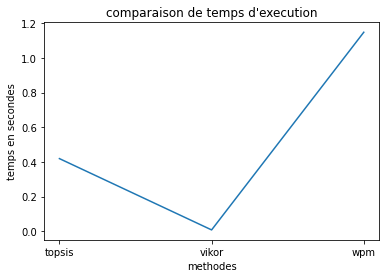

In [ ]:
a_t = [0.419,0.007,1.149]
b = ['topsis', 'vikor', 'wpm']
plt.plot(b,a_t)
plt.ylabel('temps en secondes')
plt.xlabel('methodes')
plt.title("comparaison de temps d'execution")
plt.show()

####**Cas 2: 10 alternatives et 4 criteres**

Determination de Dataframe

In [ ]:
data_2 = dataframe[dataframe.columns[8:]]
data_2.head()

,battery charging 100%,battery charging 80%,battery capacity,price
0,10.0,120,99.0,120.0
1,10.0,120,99.0,90.0
2,4.0,30,24.0,25.0
3,8.0,40,24.2,50.0
4,4.5,15,10.5,12.9


Types

In [ ]:
types_2 = np.array([-1, -1, 1, -1])

Weights

In [ ]:
weights_2 = np.array([0.1111, 0.1111, 0.1111, 0.1111])

UTilisation des methodes deja implementes

1.   **TOPSIS**

In [ ]:
topsis_data2 = data_2.copy()

In [ ]:
topsis(topsis_data2, weights_2, types_2)

In [ ]:
topsis_data2

,battery charging 100%,battery charging 80%,battery capacity,price,distance positive,distance negative,Topsis Score,rank
0,10.0,0.060413,0.070709,0.076980,0.084037,0.068705,0.449810,8.0
1,10.0,0.060413,0.070709,0.057735,0.086213,0.049460,0.364553,9.0
2,4.0,0.015103,0.017142,0.016038,0.062517,0.070588,0.530320,6.0
3,8.0,0.020138,0.017284,0.032075,0.048377,0.071012,0.594796,1.0
4,4.5,0.007552,0.007499,0.008275,0.068751,0.082400,0.545151,4.0
5,4.5,0.007552,0.007499,0.009943,0.067084,0.082417,0.551280,3.0
6,7.0,0.017620,0.011428,0.011996,0.066308,0.073207,0.524726,7.0
7,8.0,0.017620,0.016070,0.020207,0.058779,0.070420,0.545049,5.0
8,6.0,0.005034,0.024998,0.028868,0.051196,0.074701,0.593352,2.0
9,8.0,0.060413,0.024998,0.015653,0.084463,0.046302,0.354086,10.0


2.   **VIKOR**



In [ ]:
vikor_data2 = data_2.copy()

In [ ]:
vikor(vikor_data2, weights_2, types_2)

In [ ]:
vikor_data2

,battery charging 100%,battery charging 80%,battery capacity,price,R,S,VIKOR index,rank
0,10.0,120,99.0,120.0,0.111,0.333,1.000,1.0
1,10.0,120,99.0,90.0,0.111,0.302,0.907,2.0
2,4.0,30,24.0,25.0,0.094,0.127,0.175,9.0
3,8.0,40,24.2,50.0,0.094,0.237,0.506,4.0
4,4.5,15,10.5,12.9,0.111,0.125,0.375,8.0
5,4.5,15,10.5,15.5,0.111,0.128,0.384,7.0
6,7.0,35,16.0,18.7,0.104,0.191,0.489,5.0
7,8.0,35,22.5,31.5,0.096,0.215,0.464,6.0
8,6.0,10,35.0,45.0,0.080,0.151,0.078,10.0
9,8.0,120,35.0,24.4,0.111,0.277,0.832,3.0


3.   **WPM**




In [ ]:
wpm_data2 = data_2.copy()

In [ ]:
wpm(wpm_data2, weights_2, types_2)

In [ ]:
wpm_data2

,battery charging 100%,battery charging 80%,battery capacity,price,wpm score,rank
0,0.903210,0.758757,1.000000,0.780530,0.534911,10.0
1,0.903210,0.758757,1.000000,0.805880,0.552283,9.0
2,1.000000,0.885099,0.854331,0.929128,0.702576,4.0
3,0.925882,0.857257,0.855120,0.860262,0.583881,7.0
4,0.987000,0.955952,0.779362,1.000000,0.735347,2.0
5,0.987000,0.955952,0.779362,0.979807,0.720498,3.0
6,0.939720,0.870070,0.816700,0.959588,0.640767,5.0
7,0.925882,0.870070,0.848228,0.905575,0.618794,6.0
8,0.955952,1.000000,0.890904,0.870391,0.741279,1.0
9,0.925882,0.758757,0.890904,0.931639,0.583092,8.0


**Comparaison des methodes**

In [ ]:
a = [f'A{i+1}' for i in range(10)]
b2 = topsis_data2['rank'].to_numpy()
c2 = vikor_data2['rank'].to_numpy()
d2 = wpm_data2['rank'].to_numpy()
t_d2 = Table([a, b2, c2, d2], names=('alternatives', 'TOPSIS', 'VIKOR', 'WPM'))
t_d2

alternatives,TOPSIS,VIKOR,WPM
str3,float64,float64,float64
A1,8.0,1.0,10.0
A2,9.0,2.0,9.0
A3,6.0,9.0,4.0
A4,1.0,4.0,7.0
A5,4.0,8.0,2.0
A6,3.0,7.0,3.0
A7,7.0,5.0,5.0
A8,5.0,6.0,6.0
A9,2.0,10.0,1.0


Cosine similarity

In [ ]:
CS2 = []
# topsis vs vikor
CS2.append(np.dot(b2,c2)/(norm(b2)*norm(c2)))
# topsis vs wpm
CS2.append(np.dot(b2,d2)/(norm(b2)*norm(d2)))
# vikor vs wpm
CS2.append(np.dot(c2,d2)/(norm(c2)*norm(d2)))

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t2_2 = Table([a, CS2], names=('methodes', 'Cosine similarity'))
t2_2

methodes,Cosine similarity
str14,float64
topsis & vikor,0.6545454545454547
topsis & wpm,0.9246753246753248
vikor & wpm,0.5818181818181819


Calcul de coefficient de Kendall

In [ ]:
Kt2 = []
# topsis vs vikor
Kt2.append(stats.kendalltau(b2, c2)[0])
# topsis vs wpm
Kt2.append(stats.kendalltau(b2, d2)[0])
# vikor vs wpm
Kt2.append(stats.kendalltau(c2, d2)[0])

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t3_2 = Table([a, Kt2], names=('methodes', 'Kendall’s tau'))
t3_2

methodes,Kendall’s tau
str14,float64
topsis & vikor,-0.4222222222222222
topsis & wpm,0.4666666666666666
vikor & wpm,-0.8666666666666666


Calcul de coefficient de spearman

In [ ]:
Sr2 = []
# topsis vs vikor
Sr2.append(stats.spearmanr(b2, c2)[0])
# topsis vs wpm
Sr2.append(stats.spearmanr(b2, d2)[0])
# vikor vs wpm
Sr2.append(stats.spearmanr(c2, d2)[0])

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t4_2 = Table([a, Sr2], names=('methodes', 'Spearman s rho'))
t4_2

methodes,Spearman s rho
str14,float64
topsis & vikor,-0.6121212121212121
topsis & wpm,0.6484848484848483
vikor & wpm,-0.9515151515151514


Temps d'execution

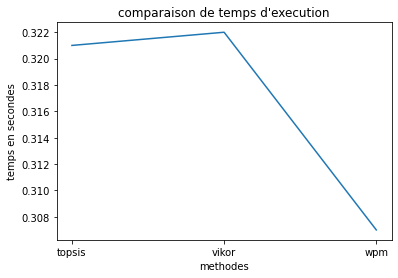

In [ ]:
a_t2 = [0.321,0.322,0.307]
b = ['topsis', 'vikor', 'wpm']
plt.plot(b,a_t2)
plt.ylabel('temps en secondes')
plt.xlabel('methodes')
plt.title("comparaison de temps d'execution")
plt.show()

####**cas 3: 5 alternatives et 9 criteres**

Determination de Dataframe

In [ ]:
data_3 = dataframe.iloc[0:5,3:]
data_3.head()

,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price
0,3000,96,145,200,610,10.0,120,99.0,120.0
1,2000,100,145,200,610,10.0,120,99.0,90.0
2,705,120,170,80,270,4.0,30,24.0,25.0
3,613,140,180,140,400,8.0,40,24.2,50.0
4,350,100,110,30,196,4.5,15,10.5,12.9


Utilisation des methodes deja implementes



1.   **TOPSIS**

In [ ]:
topsis_data3 = data_3.copy()

In [ ]:
topsis(topsis_data3, weights, types)

In [ ]:
topsis_data3

,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price,distance positive,distance negative,Topsis Score,rank
0,3000,0.042420,0.047412,0.067960,0.067251,0.064117,0.075088,0.076129,0.083015,0.097247,0.111896,0.535019,2.0
1,2000,0.044188,0.047412,0.067960,0.067251,0.064117,0.075088,0.076129,0.062261,0.099107,0.099394,0.500722,3.0
2,705,0.053025,0.055586,0.027184,0.029767,0.025647,0.018772,0.018455,0.017295,0.095664,0.086141,0.473811,4.0
3,613,0.061863,0.058856,0.047572,0.044099,0.051294,0.025029,0.018609,0.034590,0.061781,0.099678,0.617358,1.0
4,350,0.044188,0.035967,0.010194,0.021609,0.028853,0.009386,0.008074,0.008924,0.113972,0.094665,0.453732,5.0


2.   **VIKOR**


In [ ]:
vikor_data3 = data_3.copy()

In [ ]:
vikor(vikor_data3, weights, types)

In [ ]:
vikor_data3

,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price,R,S,VIKOR index,rank
0,3000,96,145,200,610,10.0,120,99.0,120.0,0.111,0.500,0.611,3.0
1,2000,100,145,200,610,10.0,120,99.0,90.0,0.111,0.501,0.613,2.0
2,705,120,170,80,270,4.0,30,24.0,25.0,0.096,0.455,0.061,5.0
3,613,140,180,140,400,8.0,40,24.2,50.0,0.100,0.429,0.119,4.0
4,350,100,110,30,196,4.5,15,10.5,12.9,0.111,0.666,1.000,1.0


3.   **WPM**



In [ ]:
wpm_data3 = data_3.copy()

In [ ]:
wpm(wpm_data3, weights, types)

In [ ]:
wpm_data3

,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price,wpm score,rank
0,1.000000,0.958949,0.976264,1.000000,1.000000,0.903210,0.793719,1.000000,0.780530,0.523851,1.0
1,0.955952,0.963308,0.976264,1.000000,1.000000,0.903210,0.793719,1.000000,0.805880,0.519391,2.0
2,0.851384,0.983020,0.993670,0.903210,0.913428,1.000000,0.925882,0.854331,0.929128,0.504255,3.0
3,0.838260,1.000000,1.000000,0.961148,0.954198,0.925882,0.896757,0.855120,0.860262,0.469565,4.0
4,0.787658,0.963308,0.946756,0.809960,0.881494,0.987000,1.000000,0.779362,1.000000,0.394530,5.0


**Comparaison des methodes**

In [ ]:
a3 = [f'A{i+1}' for i in range(5)]
b3 = topsis_data3['rank'].to_numpy()
c3 = vikor_data3['rank'].to_numpy()
d3 = wpm_data3['rank'].to_numpy()
t_d3 = Table([a3, b3, c3, d3], names=('alternatives', 'TOPSIS', 'VIKOR', 'WPM'))
t_d3

alternatives,TOPSIS,VIKOR,WPM
str2,float64,float64,float64
A1,2.0,3.0,1.0
A2,3.0,2.0,2.0
A3,4.0,5.0,3.0
A4,1.0,4.0,4.0
A5,5.0,1.0,5.0


Cosine similariry

In [ ]:
CS3 = []
# topsis vs vikor
CS3.append(np.dot(b3,c3)/(norm(b3)*norm(c3)))
# topsis vs wpm
CS3.append(np.dot(b3,d3)/(norm(b3)*norm(d3)))
# vikor vs wpm
CS3.append(np.dot(c3,d3)/(norm(c3)*norm(d3)))

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t2_3 = Table([a, CS3], names=('methodes', 'Cosine similarity'))
t2_3

methodes,Cosine similarity
str14,float64
topsis & vikor,0.7454545454545455
topsis & wpm,0.8909090909090909
vikor & wpm,0.7818181818181819


Calcul de coefficient de Kendall

In [ ]:
Kt3 = []
# topsis vs vikor
Kt3.append(stats.kendalltau(b3, c3)[0])
# topsis vs wpm
Kt3.append(stats.kendalltau(b3, d3)[0])
# vikor vs wpm
Kt3.append(stats.kendalltau(c3, d3)[0])

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t3_3 = Table([a, Kt3], names=('methodes', 'Kendall’s tau'))
t3_3

methodes,Kendall’s tau
str14,float64
topsis & vikor,-0.39999999999999997
topsis & wpm,0.39999999999999997
vikor & wpm,-0.19999999999999998


Calcul de coefficient de spearman

In [ ]:
Sr3 = []
# topsis vs vikor
Sr3.append(stats.spearmanr(b3, c3)[0])
# topsis vs wpm
Sr3.append(stats.spearmanr(b3, d3)[0])
# vikor vs wpm
Sr3.append(stats.spearmanr(c3, d3)[0])

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t4_3 = Table([a, Sr3], names=('methodes', 'Spearman’s rho'))
t4_3

methodes,Spearman’s rho
str14,float64
topsis & vikor,-0.39999999999999997
topsis & wpm,0.39999999999999997
vikor & wpm,-0.19999999999999998


Temps d'execution

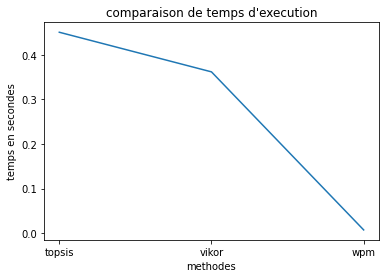

In [ ]:
a_t3 = [0.451,0.362,0.007]
b = ['topsis', 'vikor', 'wpm']
plt.plot(b,a_t3)
plt.ylabel('temps en secondes')
plt.xlabel('methodes')
plt.title("comparaison de temps d'execution")
plt.show()

####**Cas 4: 5 alternatives et 4 criteres**

Determination de dataframe

In [ ]:
data_4 = dataframe.iloc[0:5,8:]
data_4.head()

,battery charging 100%,battery charging 80%,battery capacity,price
0,10.0,120,99.0,120.0
1,10.0,120,99.0,90.0
2,4.0,30,24.0,25.0
3,8.0,40,24.2,50.0
4,4.5,15,10.5,12.9


Utilisation des methodes deja implementes



1.   **TOPSIS**


In [ ]:
topsis_data4 = data_4.copy()

In [ ]:
topsis(topsis_data4, weights_2, types_2)

In [ ]:
topsis_data4

,battery charging 100%,battery charging 80%,battery capacity,price,distance positive,distance negative,Topsis Score,rank
0,10.0,0.075088,0.076129,0.083015,0.094594,0.074091,0.439226,4.0
1,10.0,0.075088,0.076129,0.062261,0.096844,0.053337,0.355152,5.0
2,4.0,0.018772,0.018455,0.017295,0.067194,0.081041,0.546708,3.0
3,8.0,0.025029,0.018609,0.034590,0.051969,0.080455,0.607559,1.0
4,4.5,0.009386,0.008074,0.008924,0.074091,0.094594,0.560774,2.0




2.   **VIKOR**



In [ ]:
vikor_data4 = data_4.copy()

In [ ]:
vikor(vikor_data4, weights_2, types_2)

In [ ]:
vikor_data4

,battery charging 100%,battery charging 80%,battery capacity,price,R,S,VIKOR index,rank
0,10.0,120,99.0,120.0,0.111,0.333,1.000,1.0
1,10.0,120,99.0,90.0,0.111,0.302,0.909,2.0
2,4.0,30,24.0,25.0,0.094,0.123,0.009,5.0
3,8.0,40,24.2,50.0,0.094,0.233,0.332,4.0
4,4.5,15,10.5,12.9,0.111,0.120,0.375,3.0




3.   **WPM**



In [ ]:
wpm_data4 = data_4.copy()

In [ ]:
wpm(wpm_data4, weights_2, types_2)

In [ ]:
wpm_data4

,battery charging 100%,battery charging 80%,battery capacity,price,wpm score,rank
0,0.903210,0.793719,1.000000,0.780530,0.559558,5.0
1,0.903210,0.793719,1.000000,0.805880,0.577731,4.0
2,1.000000,0.925882,0.854331,0.929128,0.734949,2.0
3,0.925882,0.896757,0.855120,0.860262,0.610785,3.0
4,0.987000,1.000000,0.779362,1.000000,0.769230,1.0


**Comparaison des methodes**

In [ ]:
a3 = [f'A{i+1}' for i in range(5)]
b4 = topsis_data4['rank'].to_numpy()
c4 = vikor_data4['rank'].to_numpy()
d4 = wpm_data4['rank'].to_numpy()
t_d4 = Table([a3, b4, c4, d4], names=('alternatives', 'TOPSIS', 'VIKOR', 'WPM'))
t_d4

alternatives,TOPSIS,VIKOR,WPM
str2,float64,float64,float64
A1,4.0,1.0,5.0
A2,5.0,2.0,4.0
A3,3.0,5.0,2.0
A4,1.0,4.0,3.0
A5,2.0,3.0,1.0


Cosine similarity

In [ ]:
CS4 = []
# topsis vs vikor
CS4.append(np.dot(b4,c4)/(norm(b4)*norm(c4)))
# topsis vs wpm
CS4.append(np.dot(b4,d4)/(norm(b4)*norm(d4)))
# vikor vs wpm
CS4.append(np.dot(c4,d4)/(norm(c4)*norm(d4)))

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t2_4 = Table([a, CS4], names=('methodes', 'Cosine similarity'))
t2_4

methodes,Cosine similarity
str14,float64
topsis & vikor,0.7090909090909091
topsis & wpm,0.9272727272727272
vikor & wpm,0.6909090909090909


Calcul de coefficient de Kendall

In [ ]:
Kt4 = []
# topsis vs vikor
Kt4.append(stats.kendalltau(b4, c4)[0])
# topsis vs wpm
Kt4.append(stats.kendalltau(b4, d4)[0])
# vikor vs wpm
Kt4.append(stats.kendalltau(c4, d4)[0])

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t3_4 = Table([a, Kt4], names=('methodes', 'Kendall’s tau'))
t3_4

methodes,Kendall’s tau
str14,float64
topsis & vikor,-0.39999999999999997
topsis & wpm,0.39999999999999997
vikor & wpm,-0.6


Calcul de coefficient de Spearman

In [ ]:
Sr4 = []
# topsis vs vikor
Sr4.append(stats.spearmanr(b4, c4)[0])
# topsis vs wpm
Sr4.append(stats.spearmanr(b4, d4)[0])
# vikor vs wpm
Sr4.append(stats.spearmanr(c4, d4)[0])

In [ ]:
a = ['topsis & vikor', 'topsis & wpm', 'vikor & wpm']
t4_4 = Table([a, Sr4], names=('methodes', 'Spearman’s rho'))
t4_4

methodes,Spearman’s rho
str14,float64
topsis & vikor,-0.6
topsis & wpm,0.6
vikor & wpm,-0.7


Temps d'execution

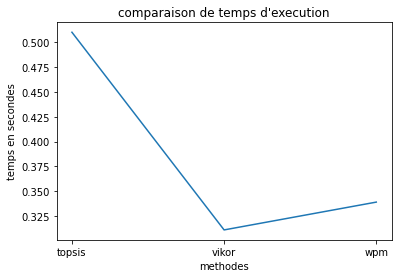

In [ ]:
a_t4 = [0.51,0.311,0.339]
b = ['topsis', 'vikor', 'wpm']
plt.plot(b,a_t4)
plt.ylabel('temps en secondes')
plt.xlabel('methodes')
plt.title("comparaison de temps d'execution")
plt.show()